 # Building system multi-step identification
 Comparison of identified predictive distribution with ground truth (considering a Kalman filter correction step)
 ## Import packages

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import sys

sys.path.append(os.path.join('..', '..'))
import blrsmpc
from blrsmpc.sysid import sysid as sid
colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']
blrsmpc.plotconfig.config_mpl(os.path.join('..', '..', 'blrsmpc', 'plotconfig', 'notation.tex'))

 ## System generation
 - Define initial state distribution
 - Define process and measurement noise
 - Define prediction horizon
 - Define input signal

 Generate setup files for data generation. We compare two data-sets:
 - One with a large number of samples
 - One with a small number of samples

In [10]:
# Initial state mean and covariance
# Used for sampling and for the KF
sigma_x0 = np.array([2,2,2,2,5])
x0_bar = np.array([20,20,20,20,15])

def get_x0() -> np.ndarray:
    # x = [T_1 T_2 T_3 T_4 T_0]
    x0 = np.random.randn(5)*sigma_x0 + x0_bar
    x0 = x0.reshape(-1,1)
    return x0

# Process and measurement noise variances
sig_x = np.array([0.0,0.0,0.0,0.0,0.5]) 
sig_y = np.ones(5)*0.1
T_ini = 1
N = 12


sys_generator = sid.SystemGenerator(
    sys_type=sid.SystemType.BUILDING,
    sig_x=sig_x,
    sig_y=sig_y,
    dt=3600,
    case_kwargs={'state_feedback': True, 'x0': get_x0}
)

# Prepare three data sets 

setup_mlarge = sid.DataGeneratorSetup(T_ini, N, n_samples=1000, sig_x=sig_x, sig_y=sig_y, dt=3600)
setup_mlow = sid.DataGeneratorSetup(T_ini, N, n_samples=100, sig_x=sig_x, sig_y=sig_y, dt=3600)
setup_test = sid.DataGeneratorSetup(T_ini, N, n_samples=1, sig_x=sig_x, sig_y=sig_y, dt=3600)

# Class that generates a pseudo-random input signal
random_input = sid.RandomInput(
    n_u=5, 
    u_lb = np.array([-6,-6,-6,-6, 0]).reshape(-1,1),
    u_ub = np.array([6,6,6,6,30]).reshape(-1,1),
    switch_prob=np.array([0.5, 0.5, 0.5, 0.5, 0.04]).reshape(-1,1)
    )

 ## Generate the data with the chosen configuration

In [11]:
np.random.seed(99)

data_mlarge = sid.DataGenerator(sys_generator, setup_mlarge, random_input)
data_mlow = sid.DataGenerator(sys_generator, setup_mlow, random_input)
data_test = sid.DataGenerator(sys_generator, setup_test, random_input)

In [12]:
assert np.linalg.matrix_rank(data_mlow.M) == data_mlow.M.shape[0], "M matrix is not full rank"

 ## System identification with multi-step model

In [13]:
msm_settings = {
    'estimate_covariance': True,
    'scale_x': True,
    'scale_y': True,
    'add_bias': True,
    'type': 'mle'
}

msm_mlarge = sid.MultistepModel(**msm_settings)
msm_mlarge.fit(data_mlarge)
msm_mlow = sid.MultistepModel(**msm_settings)
msm_mlow.fit(data_mlow)

 ## Distributed multi-step prediction
 ### With MSM

In [14]:
def eval_msm(msm: sid.MultistepModel, data: sid.DataGenerator, ind: int = 0):
    y_msm_pred, y_msm_pred_cov = msm.predict(data.M[:,[ind]].T, uncert_type="cov", with_noise_variance=True)
    y_msm_pred = y_msm_pred.reshape(-1,data.n_y)
    y_msm_pred_std = np.sqrt(np.diag(y_msm_pred_cov)).reshape(-1,data.n_y)

    return {'mean': y_msm_pred, 'std': y_msm_pred_std, 'cov': y_msm_pred_cov}

msm_mlarge_pred = eval_msm(msm_mlarge, data_test)
msm_mlow_pred = eval_msm(msm_mlow, data_test)

 ### Ground truth with Kalman filter correction step

In [15]:
# Get system for simulation and set the process and meas noise to zero (we use it for an open-loop simulation)
test_sys = sys_generator()
test_sys.sig_x = 0*sig_x.reshape(-1,1)
test_sys.sig_y = 0*sig_y.reshape(-1,1)
# Get covariances and calculate the Kalman gain
Sigma_x0 =  np.diag(sigma_x0**2)
Sigma_y = np.diag((sig_y**2).flatten())
Sigma_x = np.diag((sig_x**2).flatten())
L = Sigma_x0@np.linalg.inv(Sigma_x0 + Sigma_y)
# Make the single KF correction step
y0 = data_test.Y_T_ini[:,0].reshape(-1,1)
x0_bar_new = L@y0 + (np.eye(5) - L)@x0_bar.reshape(-1,1)
P0_new = (np.eye(5) - L)@Sigma_x0

# Reset the system with the new initial state and covariance
test_sys.reset(x0=x0_bar_new, P0=P0_new)
u_seq = data_test.U_L[:, 0].reshape(-1, data_test.n_u)
# Make the open-loop simulation with the true model and propagate the uncertainty
for k in range(N+1):
    test_sys.make_step(u_seq[k,:].reshape(-1,1), Q=Sigma_x, R=Sigma_y)

# Extract standard deviation and mean of the predicted output
y_tru_pred_std = np.sqrt(np.diagonal(test_sys.P_y[1:], axis1=1, axis2=2))
y_tru_pred = test_sys.y[1:]

 ## Plot the results
 ### Prepare function for plotting the covariance ellipses

In [16]:
label_list =['$T_1$ [$^\circ$C]', '$T_2$ [$^\circ$C]', '$T_3$ [$^\circ$C]', '$T_4$ [$^\circ$C]', '$T_{a}$ [$^\circ$C]'] 

def plot_correlation(ax, mean, cov, **kwargs):
    # m_x = m_y = 0
    for i in range(data_test.n_y):
        for j in range(data_test.n_y):
            if i<j:
                ax[i,j].axis('off')
                continue

            cov_ij = cov[np.ix_([j,i],[j,i])]
            m_x = mean[j]
            m_y = mean[i]

            if i==j:
                cov_ij = np.diag(np.diag(cov_ij))
            blrsmpc.helper.plot_cov_as_ellipse(m_x, m_y, cov=cov_ij, ax=ax[i,j], n_std=3, **kwargs)
            ax[i,j].relim()
            ax[i,j].autoscale()
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            ax[i,j].axis('equal')

 ### Final plot for the results

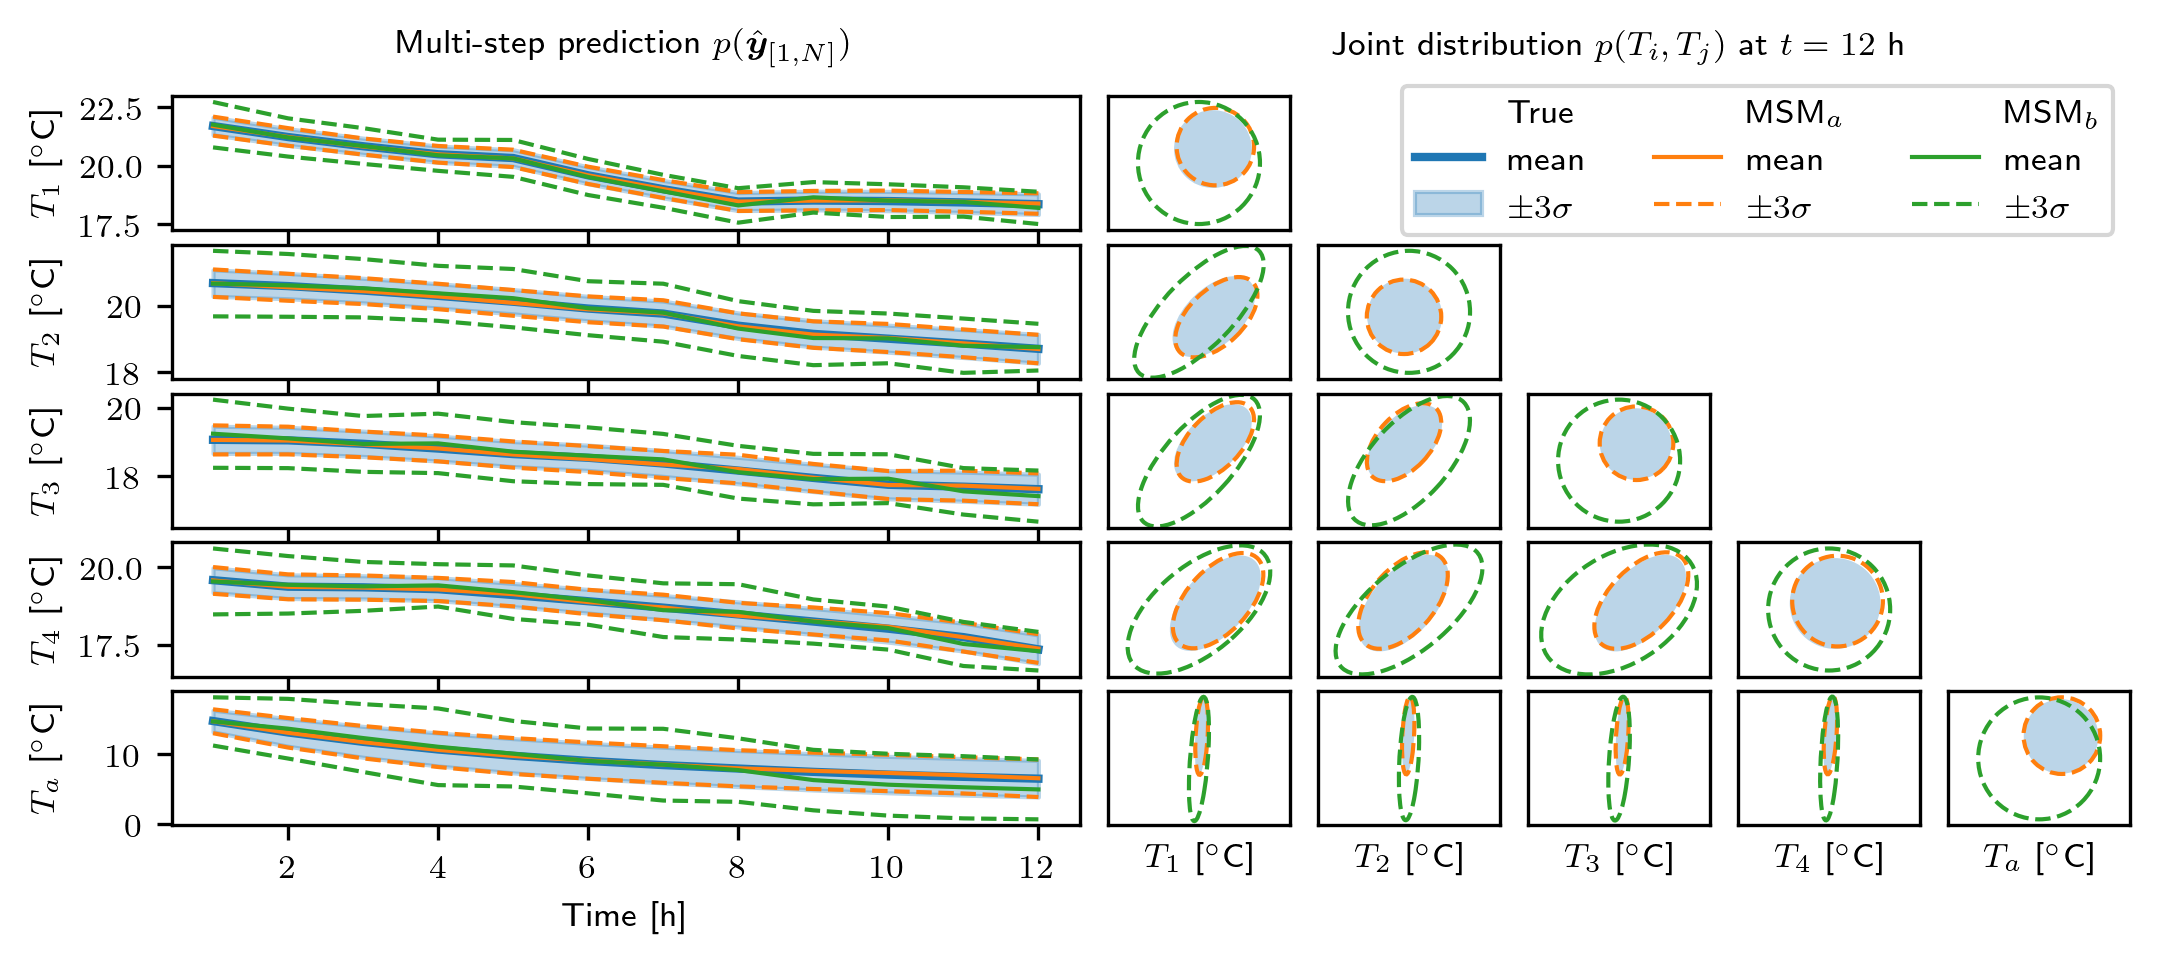

In [17]:
gridspec_dict = {'width_ratios': [5,1,1,1,1,1]}
figsize = (blrsmpc.plotconfig.textwidth, blrsmpc.plotconfig.textwidth/2.5)
fig, ax = plt.subplots(data_test.n_y, data_test.n_y + 1,figsize=figsize, dpi=300, gridspec_kw=gridspec_dict)


t = data_test.sim_results[0].time[T_ini:]/3600
for i in range(data_test.n_y):

    ax[i,0].plot(t, y_tru_pred[:,i], '-', linewidth=2, label="true", color=colors[0])
    ax[i,0].fill_between(t, y_tru_pred[:,i]-3*y_tru_pred_std[:,i], y_tru_pred[:,i]+3*y_tru_pred_std[:,i], alpha=0.3, color=colors[0])
    ax[i,0].plot(t, msm_mlarge_pred['mean'][:,i], '-', linewidth=1, label="MSM", color=colors[1])
    ax[i,0].plot(t, msm_mlarge_pred['mean'][:,i]+3*msm_mlarge_pred['std'][:,i], '--', linewidth=1, label="MSM", color=colors[1])
    ax[i,0].plot(t, msm_mlarge_pred['mean'][:,i]-3*msm_mlarge_pred['std'][:,i], '--', linewidth=1, label="MSM", color=colors[1])
    ax[i,0].plot(t, msm_mlow_pred['mean'][:,i], '-', linewidth=1, label="MSM", color=colors[2])
    ax[i,0].plot(t, msm_mlow_pred['mean'][:,i]+3*msm_mlow_pred['std'][:,i], '--', linewidth=1, label="MSM", color=colors[2])
    ax[i,0].plot(t, msm_mlow_pred['mean'][:,i]-3*msm_mlow_pred['std'][:,i], '--', linewidth=1, label="MSM", color=colors[2])
    if i<data_test.n_y-1:
        ax[i,0].set_xticklabels([])

    ax[i,0].set_ylabel(label_list[i])
    ax[-1,i+1].set_xlabel(label_list[i])

ax[-1,0].set_xlabel('Time [h]')


corr_ax = ax[:, 1:]
plot_correlation(corr_ax, test_sys.y[-1], test_sys.P_y[-1], facecolor=colors[0], alpha=.3)
plot_correlation(corr_ax, msm_mlarge_pred['mean'][-1], msm_mlarge_pred['cov'][-5:,-5:], edgecolor=colors[1], linestyle='--', linewidth=1)
plot_correlation(corr_ax, msm_mlow_pred['mean'][-1], msm_mlow_pred['cov'][-5:,-5:], edgecolor=colors[2], linestyle='--', linewidth=1)
ax[0,-1].plot([],[], linewidth=0, label="True")
ax[0,-1].plot([],[], linewidth=2, color=colors[0], label="mean")
ax[0,-1].fill_between([],[],[], color=colors[0], label="$\pm 3\sigma$", alpha=0.3)
ax[0,-1].plot([],[], linewidth=0, label=r"MSM$_{a}$")
ax[0,-1].plot([],[], linewidth=1, color=colors[1], label="mean")
ax[0,-1].plot([],[], '--', linewidth=1, color=colors[1], label="$\pm 3\sigma$")
ax[0,-1].plot([],[], linewidth=0, label=r"MSM$_{b}$")
ax[0,-1].plot([],[], linewidth=1, color=colors[2], label="mean")
ax[0,-1].plot([],[], '--', linewidth=1, color=colors[2], label="$\pm 3\sigma$")

fig.align_ylabels()
fig.tight_layout(pad=0)

ax[0,-1].legend(loc='upper right', ncol=3, bbox_to_anchor=(1.0, 1.2))
ax[0,0].set_title(r'Multi-step prediction $p(\hat\vy_{[1,N]})$')
ax[0,3].set_title('Joint distribution $p(T_i,T_j)$ at $t=12$ h')

savepath = os.path.join('..', '..', '..', '2023_CDC_L-CSS_Paper_Stochastic_MSM', 'figures')
savename = 'sid_building_compare_kf_pred'
fig.savefig(os.path.join(savepath, savename + '.pgf'), bbox_inches='tight', format='pgf')